In [1]:
# Importing packages
import torch
import os 

# Defining training and testing paths
training_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\training"
testing_path=r"C:\Users\97158\Desktop\Apziva\Project 4-MonReader\images\testing"  

In [2]:
# Specifying mean and SD from imagenet dataset statistics
Mean= [0.485, 0.456, 0.406]
STD= [0.229, 0.224, 0.225]

# Specifying training hyperparameters
Image_size=256
Batch_size= 128
Pred_batch_size= 4
EPOCHS=21
LR=0.0001

# Determining the device type
Device= torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [28]:
# Creating the directory if it doesn't exist
os.makedirs("model_output", exist_ok=True)

# Defining paths to store trained model
Model_path= os.path.join("model_output","model.pth")

Training our Classifier


In [16]:
# Importing all the packages

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import Normalize
from torchvision.transforms import Resize
from torchvision.transforms import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import Softmax
from torch import optim
from tqdm import tqdm
from matplotlib import pyplot as plt 
import argparse


In [4]:
# Constructing an argument parser to choose between models from the command line

import sys
sys.argv=['']
del sys

ap=argparse.ArgumentParser()
ap.add_argument('-m','--model',type=str,default='vgg', choices=['vgg','resnet'],
                help='Name of the model')
args=vars(ap.parse_args())


In [5]:
if args['model']=='vgg':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','vgg11',weights='VGG11_Weights.DEFAULT', skip_validation=True)

    for param in basemodel.parameters():
        param.requires_grad=False
elif args['model']=='resnet':
    basemodel=torch.hub.load('pytorch/vision:v0.10.0','resnet18',weights='ResNet18_Weights.DEFAULT', skip_validation=True)

    lastLayer=8
    currentLayer=1

    #Looping over the child layers of the model
    for child in basemodel.children():

        if currentLayer<lastLayer:
            for param in child.parameters():
                param.requires_grad=False
        else:
            break
        currentLayer+=1

Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


In [6]:
# Defining the tranform pipeline

# Create training dataset using Imagefolder
trainTransform=Compose([
    RandomResizedCrop(Image_size),
    RandomHorizontalFlip(),
    RandomRotation(90),
    ToTensor(),
    Normalize(Mean, STD)
])

# Creating training dataset using Imagefolder
train_dataset=ImageFolder(training_path,trainTransform)

In [7]:
# Importing the necessary packages
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Defining the dataloader function
def get_Dataloader(Dataset, Batch_size, shuffle=True):
    dl=DataLoader(Dataset,Batch_size,shuffle=shuffle)
    return dl
# Train_Val Dataset Splitter

def train_val_split(Dataset, val_split=0.2):

    total_size=len(Dataset)
    (train_idx, val_idx)= train_test_split(list(range(total_size)),test_size=val_split)

    train_set=Subset(Dataset,train_idx)
    test_set=Subset(Dataset,val_idx)

    return train_set,test_set

In [8]:
# Creating training and validation split
(TrainDataset, ValDataset)= train_val_split(Dataset=train_dataset)

# Creating training and validation data loaders
train_laoder=get_Dataloader(Dataset=TrainDataset, Batch_size=Batch_size)
val_loader=get_Dataloader(Dataset=ValDataset, Batch_size=Batch_size)

In [9]:
# Calculating Steps per epoch for training and validation set
train_step= len(TrainDataset)/Batch_size
val_step= len(ValDataset)/Batch_size

print("Train_Step: {:.2f}\nVal_step: {:.2f}".format(train_step, val_step))

#Initializing the results directory to store history for plotting
Train_Val_Hist={
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]}

Train_Step: 14.95
Val_step: 3.74


In [37]:
# Creating the classifier for our task

from torch.nn import Linear
from torch.nn import Module

class classifier(Module):
    def __init__(self, baseModel, numclasses, model):
        super().__init__()

        self.baseModel=baseModel

        if model=='vgg':
            self.fc= Linear(baseModel.classifier[6].out_features, numclasses)
        elif model=='resnet':
            self.fc=Linear(baseModel.fc.out_features,numclasses)
                           
                           
# passing the input via our basemodel to get the features and then passing through the FC layer to get out putput logits
    def forward(self,x):
        features=self.baseModel(x)
        logits=self.fc(features)       
        return logits 

In [11]:
# Building the custom model
model= classifier(baseModel=basemodel.to(Device),numclasses=2,model=args["model"])
model=model.to(Device)

# Initializing loss function and optimizer
loss_func= CrossEntropyLoss()
loss_func=loss_func.to(Device)
optimizer=optim.Adam(model.parameters(), lr=LR)

# Initializing the softmax activation layer
activation_func=Softmax()

In [12]:
# Setting up the training epoch 
print("[INFO] Training the Network")

for e in range(EPOCHS):
    model.train()
    
    total_train_loss=0 # initializing the loss and accuracy metrics
    train_correct=0

    total_val_loss=0
    val_correct=0

#looping over training set and sending to device:
    for (image,targets) in tqdm(train_laoder):
        (image, targets)=image.to(Device), targets.to(Device)
                 
        logits=model(image)                                               #performing forward pass and calculating loss
        loss= loss_func(logits,targets)
        optimizer.zero_grad()                                             #Zeroing out the gradient 
        loss.backward()                                                   #Back propogation    
        optimizer.step()                                                  #updating the weights

        total_train_loss += loss.item()                                   # Adding loss to the total loss training

        pred=activation_func(logits)                                      # Pass the logits via Softmax functions to obtain predictions

        train_correct += (pred.argmax(dim=-1)== targets).sum().item()     # Calculating the total number of correct predictionsq        


# Evaluating val dataset
    
    #Swithching off autograd and setting it to eval mode.
    with torch.no_grad():
        model.eval()

        for (image,targets) in tqdm(val_loader):
            (image, targets)= image.to(Device),targets.to(Device)

            logits=model(image)
            loss=loss_func(logits, targets)
            total_val_loss += loss.item()

            pred=activation_func(logits)
            val_correct += (pred.argmax(dim=-1)==targets).sum().item()


    # Calculating Avg. loss and accuracy

    Avg_train_Loss= total_train_loss/ train_step
    Avg_val_loss= total_val_loss /val_step
        
    train_correct=train_correct/len(train_dataset)
    val_correct=val_correct/len(ValDataset)

    #Updating training history
    Train_Val_Hist["train_loss"].append(Avg_train_Loss)
    Train_Val_Hist["train_acc"].append(train_correct)
    Train_Val_Hist["val_loss"].append(Avg_val_loss)
    Train_Val_Hist["val_acc"].append(val_correct)
    
    # Printing training and validation info        

    print(f"[INFO] EPOCH: {e+1}/{EPOCHS}")
    print(f"Train_loss: {Avg_train_Loss:.4f}, Train_Accuracy: {train_correct:.3f}")
    print(f"Val_loss: {Avg_val_loss:.4f}, Val_Accuracy: {val_correct:.3f}")


[INFO] Training the Network


  0%|          | 0/15 [00:00<?, ?it/s]c:\Users\97158\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 4/4 [00:46<00:00, 11.66s/it]


[INFO] EPOCH: 1/15
Train_loss: 0.8007, Train_Accuracy: 0.421
Val_loss: 0.7608, Val_Accuracy: 0.539


100%|██████████| 4/4 [00:40<00:00, 10.16s/it]


[INFO] EPOCH: 2/15
Train_loss: 0.7649, Train_Accuracy: 0.430
Val_loss: 0.7693, Val_Accuracy: 0.491


100%|██████████| 4/4 [00:40<00:00, 10.07s/it]


[INFO] EPOCH: 3/15
Train_loss: 0.7362, Train_Accuracy: 0.452
Val_loss: 0.7607, Val_Accuracy: 0.528


100%|██████████| 4/4 [00:40<00:00, 10.10s/it]


[INFO] EPOCH: 4/15
Train_loss: 0.7303, Train_Accuracy: 0.441
Val_loss: 0.7239, Val_Accuracy: 0.585


100%|██████████| 4/4 [00:40<00:00, 10.13s/it]


[INFO] EPOCH: 5/15
Train_loss: 0.7046, Train_Accuracy: 0.458
Val_loss: 0.7052, Val_Accuracy: 0.614


100%|██████████| 4/4 [00:42<00:00, 10.65s/it]


[INFO] EPOCH: 6/15
Train_loss: 0.6949, Train_Accuracy: 0.463
Val_loss: 0.7085, Val_Accuracy: 0.628


100%|██████████| 4/4 [00:30<00:00,  7.55s/it]


[INFO] EPOCH: 7/15
Train_loss: 0.6881, Train_Accuracy: 0.462
Val_loss: 0.7119, Val_Accuracy: 0.576


100%|██████████| 4/4 [00:30<00:00,  7.55s/it]


[INFO] EPOCH: 8/15
Train_loss: 0.6672, Train_Accuracy: 0.475
Val_loss: 0.7383, Val_Accuracy: 0.568


100%|██████████| 4/4 [00:30<00:00,  7.63s/it]


[INFO] EPOCH: 9/15
Train_loss: 0.6929, Train_Accuracy: 0.460
Val_loss: 0.6918, Val_Accuracy: 0.618


100%|██████████| 4/4 [00:43<00:00, 10.85s/it]


[INFO] EPOCH: 10/15
Train_loss: 0.6710, Train_Accuracy: 0.485
Val_loss: 0.7087, Val_Accuracy: 0.597


100%|██████████| 4/4 [00:41<00:00, 10.34s/it]


[INFO] EPOCH: 11/15
Train_loss: 0.6670, Train_Accuracy: 0.485
Val_loss: 0.6855, Val_Accuracy: 0.630


100%|██████████| 4/4 [00:41<00:00, 10.26s/it]


[INFO] EPOCH: 12/15
Train_loss: 0.6691, Train_Accuracy: 0.477
Val_loss: 0.6895, Val_Accuracy: 0.647


100%|██████████| 4/4 [00:40<00:00, 10.15s/it]


[INFO] EPOCH: 13/15
Train_loss: 0.6714, Train_Accuracy: 0.482
Val_loss: 0.6763, Val_Accuracy: 0.630


100%|██████████| 4/4 [00:42<00:00, 10.60s/it]


[INFO] EPOCH: 14/15
Train_loss: 0.6586, Train_Accuracy: 0.490
Val_loss: 0.6851, Val_Accuracy: 0.624


100%|██████████| 4/4 [00:43<00:00, 10.77s/it]

[INFO] EPOCH: 15/15
Train_loss: 0.6546, Train_Accuracy: 0.494
Val_loss: 0.6903, Val_Accuracy: 0.624


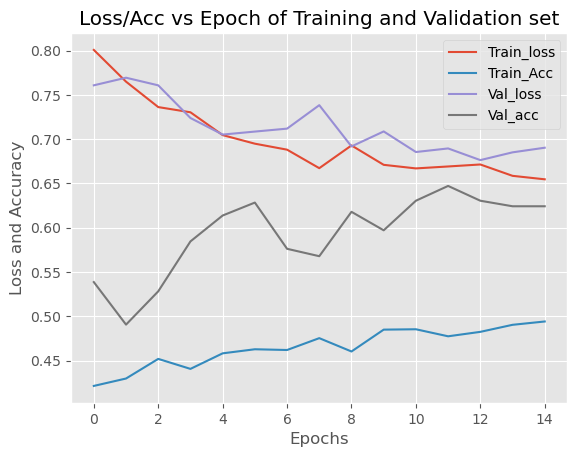

In [13]:
%matplotlib inline

plt.style.use("ggplot")
plt.figure()
plt.title("Loss/Acc vs Epoch of Training and Validation set")

plt.plot(Train_Val_Hist["train_loss"],label="Train_loss")
plt.plot(Train_Val_Hist["train_acc"],label="Train_Acc")
plt.plot(Train_Val_Hist["val_loss"],label="Val_loss")
plt.plot(Train_Val_Hist["val_acc"],label="Val_acc")

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.legend(loc="best")

plt.show()
torch.save(model.module.state_dict(), Model_path)

In [ ]:
torch.save(model.state_dict(), Model_path)

Testing our Classifier

In [56]:
testTransform=Compose([
    Resize(Image_size),
    ToTensor(),
    Normalize(mean=Mean,std=STD)
])

# Calculating inverse mean and STD
invMean=[1/m for m in Mean]
invSTD= [1/s for s in STD]

# Defining our denormalizing transform
deNormalize= transforms.Normalize(mean=invMean, std=invSTD)

#Creating test Dataset
testDataset=ImageFolder(testing_path,testTransform)

# Initializing the test dataset
testLoader= get_Dataloader(testDataset,Batch_size=Batch_size)


In [57]:
#vgg16_path = Model_path

# Load the trained weights of the VGG16 model
#model.load_state_dict(torch.load(vgg16_path))

# Initialize the ResNet18 model
resnet_model= torch.hub.load('pytorch/vision:v0.10.0','resnet18',weights=None, skip_validation=True)

#resnet18 = models.resnet18(pretrained=False)

# Transfer the weights from VGG16 to ResNet18
# Assuming the layers to transfer have similar names in both models
# for vgg_layer, resnet_layer in zip(model.children(), resnet_model.children()):
#     if hasattr(vgg_layer, "weight") and hasattr(resnet_layer, "weight"):
#         resnet_layer.weight.data = vgg_layer.weight.data
#         if hasattr(vgg_layer, "bias") and hasattr(resnet_layer, "bias"):
#             resnet_layer.bias.data = vgg_layer.bias.data


# for vgg_param, resnet_param in zip(model.parameters(), resnet_model.parameters()):
#     resnet_param.data.copy_(vgg_param.data)

vgg_fc_weight = model['fc.weight']
vgg_fc_bias = model['fc.bias']
resnet_model.fc.weight.data.copy_(vgg_fc_weight)
resnet_model.fc.bias.data.copy_(vgg_fc_bias)    

# Save the ResNet18 model with transferred weights
resnet18_path = "resnet18_with_transferred_weights.pth"
torch.save(resnet_model.state_dict(), resnet18_path)

Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


TypeError: 'classifier' object is not subscriptable

In [ ]:
# Initialize the ResNet18 model
# resnet_model= torch.hub.load('pytorch/vision:v0.10.0','resnet18',weights=None, skip_validation=True)
# resnet_model.load_weights(Model_path)

Using cache found in C:\Users\97158/.cache\torch\hub\pytorch_vision_v0.10.0


KeyError: 'model_output\\model.pth'

In [ ]:
# Building the custom model

model=classifier(baseModel=basemodel.to(Device),numclasses=2,model=resnet_model)
model=model.to(Device)

# Loading the model state (weights) and initializing the loss function

# model.load_state_dict(torch.load(Model_path))